### Prep Libraries and Pakages

In [63]:
import pandas as pd
import numpy as np
import datetime
import quandl
import config
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA

# settings to observe x amount of rows in dataframe
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 1000)
import warnings
warnings.filterwarnings("ignore")

# turn scientific values in columns to regular numerical values
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# API Key
quandl.ApiConfig.api_key = ''

### OPENS FILES

In [2]:
# North America Publicly Traded Companies
companies_data = pd.read_csv('/Users/Alfredo/Desktop/github_content/clustering-stocks/n_a_companylist.csv')
#companies_data.head()

In [3]:
# Quandl Available Companies
tickers_data = pd.read_csv('/Users/Alfredo/Desktop/github_content/clustering-stocks/WIKI-datasets-codes.csv', header=-1)
tickers_data.columns = ['Ticker', 'Description']
#tickers_data.head()

### Setting new filtered file

In [4]:
#print(companies_data.shape)
#print(tickers_data.shape)

In [5]:
# AddS WIKI/ to Symbol FeatureS
companies_data['Symbol'] = 'WIKI/' + companies_data['Symbol'].astype(str)

# Gives all North America Publicly Traded Companies available through Quandl codes
tickers_data = companies_data.loc[companies_data['Symbol'].isin(tickers_data.Ticker)]
#tickers_data.head()
#tickers_data.shape

### Open historical  data for each stock

In [6]:
#tickers = tickers_data.Symbol.tolist()
#symbols = []

#for sym in tickers:
    
    #start = ""
    #end = ""   
    #mydata = quandl.get(sym, start_date=start, end_date=end, api_key = quandl.ApiConfig.api_key)
    #mydata['Symbol'] = sym
    #symbols.append(mydata)
       
# attach tickers tables ----
#mydata = pd.concat(symbols)

# Reset index/build Date into a column ----
#mydata.reset_index(inplace=True)

#Merges tickers data features ----
#mydata = mydata.merge(tickers_data)
#mydata.head()

### Save and open historical data in new file

In [7]:
#mydata.to_csv('stocks_data_prices.csv')

In [39]:
mydata = pd.read_csv('/Users/Alfredo/Desktop/github_content/clustering-stocks/stocks_data_prices.csv')
mydata.shape

(6553424, 24)

### Data Wrangling and Feature Engineering

In [40]:
# Drop Not Needed Columns
mydata = mydata.drop(['Unnamed: 0','Open','High','Low','Close','Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Volume','Sector',
        'Industry','Name','LastSale','ADR TSO','IPOyear','Summary Quote','Unnamed: 9'], axis=1)

# Dates column into datetime64[ns] format
mydata['Date'] = pd.to_datetime(mydata['Date'])
#mydata.head()

# Builds column for publicly Traded Years
mydata['Yys_Pbl_Traded'] = mydata.groupby('Symbol').Date.transform(lambda x: x.dt.year.max() - x.dt.year.min())

# Filters dates for 2017
mydata = mydata[(mydata.Date >= '2017-01-01') & (mydata.Date < '2018-01-01')]

# Slices WIKI/ out of Symbol values
mydata['Symbol'] = mydata['Symbol'].map(lambda x: str(x)[5:])

# Changes MarketCap feature from scientific notation to integer value
mydata['MarketCap'] = mydata['MarketCap'].apply(lambda x: '%.f' % x)

# resetting indexes
mydata = mydata.set_index(['Date','Symbol']).unstack(0).stack(dropna=False).groupby(level='Symbol').ffill().bfill()

# Calculates the average daily dollars traded
avg_dtrades = mydata.groupby('Symbol').Volume.transform('mean')
avg_stk_price = mydata.groupby('Symbol')['Adj. Close'].transform('mean')
mydata['Avg_Daily_DolsTraded'] = (avg_dtrades*avg_stk_price).apply(lambda x: '%.f' % x)

# Builds daily return column
mydata['Daily_Return'] = mydata['Adj. Close'].pct_change(1)

# Mean Daily Return
d_mean_return = mydata.groupby('Symbol').Daily_Return.transform('mean').to_frame()
mydata['Avg_Daily_Return'] = d_mean_return

# Std Daily
d_std_return = mydata.groupby('Symbol').Daily_Return.transform('std').to_frame()
mydata['Std_Daily_Return'] = d_std_return

# Calculates Daily Sharpe Ratio(Calculates risk adjusted return)
# mean return - risk free rate / standard deviation
# For this formula we are assuming a risk free rate of 0(different people,different opinions)
sr = d_mean_return/d_std_return
mydata['Daily_Sharpe_Ratio'] = sr


# Dividend Yield, % paid relative to share price
avg_price = mydata.groupby('Symbol')['Adj. Close'].transform('mean')
total_dividen = mydata.groupby('Symbol')['Ex-Dividend'].transform('sum')
dividend_yield = total_dividen/avg_price
mydata['Dividend_Yield'] = dividend_yield


# Formats total values by ticker
mydata = mydata.reset_index(level=1, drop=True).groupby('Symbol').first()
mydata = mydata.drop(['Volume','Ex-Dividend','Adj. Close','Daily_Return'], axis=1).reset_index()

# Checking data values
#mydata.isnull().any()
#mydata.dtypes
#mydata.shape

# Builds object data types to numerical data types 
mydata['MarketCap'] = mydata['MarketCap'].astype('float64')
mydata['Avg_Daily_DolsTraded'] = mydata['Avg_Daily_DolsTraded'].astype('float64')

mydata.head(3)

,Symbol,MarketCap,Yys_Pbl_Traded,Avg_Daily_DolsTraded,Avg_Daily_Return,Std_Daily_Return,Daily_Sharpe_Ratio,Dividend_Yield
0,A,21722962316.000,19.000,108196770.000,0.002,0.010,0.148,0.007
1,AAN,2929260228.000,34.000,30333982.000,-0.001,0.041,-0.022,0.002
2,AAP,7534644464.000,17.000,200681623.000,0.011,0.208,0.054,0.001


### Data Split

In [10]:
#splits data
clust_train, clust_test = train_test_split(mydata, test_size=.3, random_state=123)
#print(clust_train.shape)
#print(clust_test.shape)

### Data Scale

In [48]:
# Turns data into a matrix box
data = clust_train.as_matrix(columns=[ 'MarketCap', 'Yys_Pbl_Traded','Avg_Daily_DolsTraded',
       'Avg_Daily_Return', 'Std_Daily_Return', 'Daily_Sharpe_Ratio',
       'Dividend_Yield'])

x_cols = data
# scales data
sc_clust_train = preprocessing.scale(x_cols)
#print('mean:',round(scaled_cols.mean()))
#print('std:',scaled_cols.std())

### Find Efficient # of Clusters

#### Elbow Method:

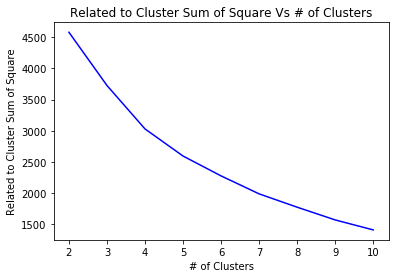

In [50]:
# Searching for elbow(optimal number of clusters)
# Average distance value to centroids
K_range = range(2,11)
y =[]

for k in K_range:
    k_means = KMeans(n_clusters= k, random_state = 1, init = 'k-means++')
    k_means.fit(sc_clust_train)
    labels=k_means.labels_
    y.append(k_means.inertia_)

plt.plot(K_range, y, color='blue')
plt.xlabel('# of Clusters')
plt.ylabel('Related to Cluster Sum of Square')
plt.title('Related to Cluster Sum of Square Vs # of Clusters')
plt.show()

#### Silhouette Method:

For n_clusters = 2 The average silhouette_score is : 0.612964845042


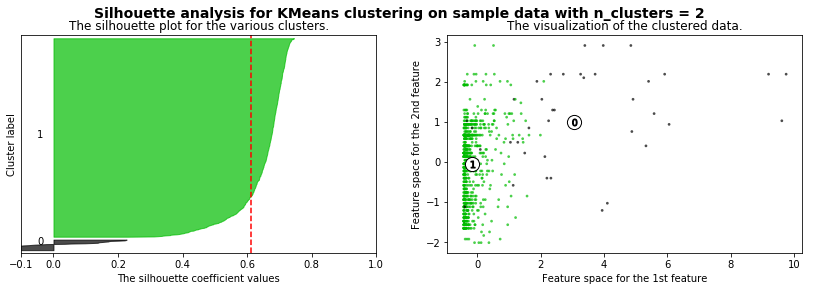

For n_clusters = 3 The average silhouette_score is : 0.561895515174


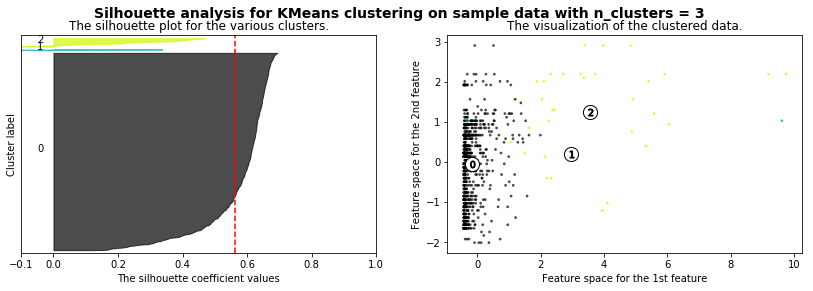

For n_clusters = 4 The average silhouette_score is : 0.264207751511


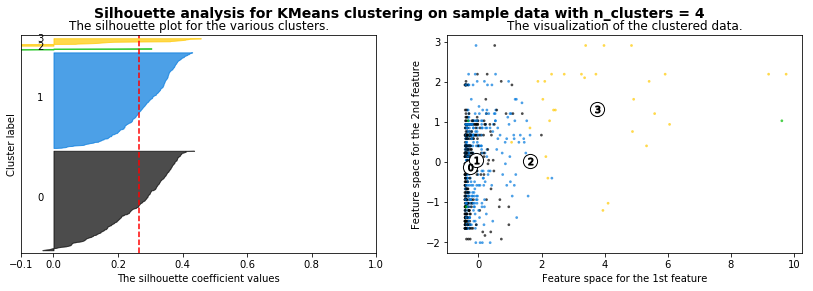

For n_clusters = 5 The average silhouette_score is : 0.283460118204


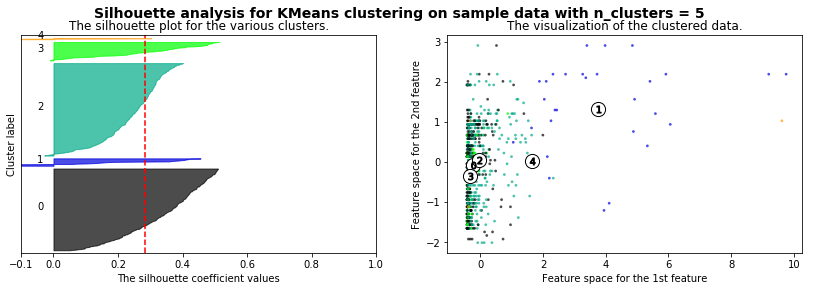

For n_clusters = 6 The average silhouette_score is : 0.287644466104


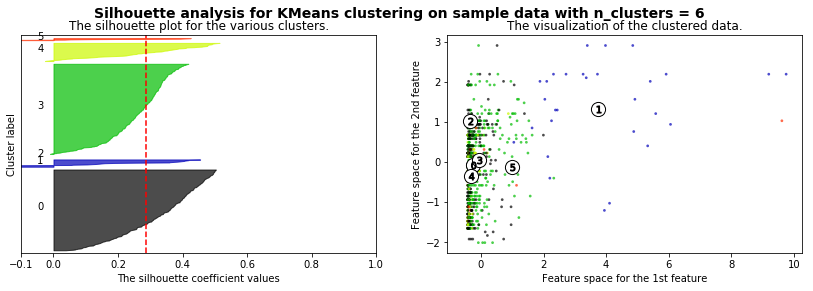

In [54]:
range_n_clusters = [2, 3, 4, 5, 6]
X= sc_clust_train

for n_clusters in range_n_clusters:
    
# SETTING THE PLOTS ONE ROW AND TWO COLUMNS FOR EACH SAMPLE, ALSO SETS THE SIZE OF EACH BOX
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)
    

# THE FIRST COLUMN BOX FOR EACH ROW(AX1) REPRESENTS THE GRAPH OF THE SILHOUETE COEFFICIENTS
   # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    
# IT FITS THE DATA AND PREDICT THE CENTROIDS/CLUSTERS 
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(sc_clust_train)
    
# IT CALCULATES THE AVERAGE SCORES FOR EACH # OF CLUSTERS, THE CLOSER TO ONE THE BETTER FIT   
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(sc_clust_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    
     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sc_clust_train, cluster_labels)
    
    
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

### Apply Clustering Model

In [56]:
# training data
X = sc_clust_train

# setting model
Kmean = KMeans(n_clusters=3)

# fiting training data
Kmean.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [57]:
# Dimension Reduction
pca_2 = PCA(2)

plot_columns = pca_2.fit_transform(sc_clust_train)
#len(plot_columns)

# Cluster/Target value given to each Individual point in dataset
#Kmean.labels_

# Centroids cordinates
#Kmean.cluster_centers_

### Visualizing Cluster

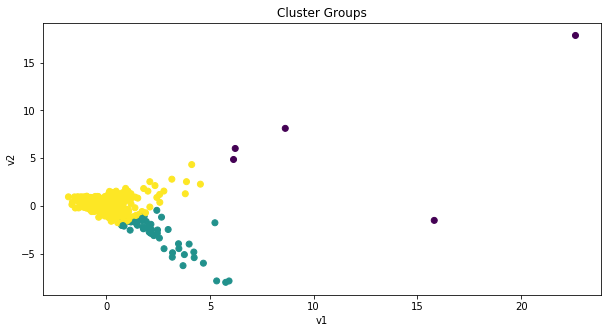

In [65]:
# plot columns
plt.figure(figsize=(10,5), )

plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=Kmean.labels_,)
plt.xlabel('v1')
plt.ylabel('v2')
plt.title('Cluster Groups')
plt.show()

### Variables' means by cluster

In [64]:
# builds variable to groupby average values
mydata_labels = clust_train

# Builds dataframe with cluster labels inside
cluster_labels = pd.DataFrame(data = Kmean.labels_)

# renames labels to cluster
cluster_labels.columns = ['Cluster']

# join datas
data_n_labels = mydata_labels.join(cluster_labels)

# calculate clustering variable means by cluster
clustergrp = data_n_labels.groupby('Cluster').mean()

# turn index from float to integer
clustergrp.index = clustergrp.index.astype(int)

# Turn years publicly traded into a interger
clustergrp.Yys_Pbl_Traded = clustergrp.Yys_Pbl_Traded.astype(int)
print('\n', "Clustering variables means by cluster")
clustergrp.head()


 Clustering variables means by cluster


,MarketCap,Yys_Pbl_Traded,Avg_Daily_DolsTraded,Avg_Daily_Return,Std_Daily_Return,Daily_Sharpe_Ratio,Dividend_Yield
Cluster,,,,,,,
0,15987237133.500,21,160588842.000,0.005,0.120,0.020,0.008
1,36647412732.941,27,150561466.765,0.003,0.082,0.011,0.022
2,14752669816.268,23,83981967.707,0.007,0.147,0.016,0.016


---

## Test Data Set

In [60]:
# Turns data into a matrix box
data_t = clust_test.as_matrix(columns=[ 'MarketCap', 'Yys_Pbl_Traded','Avg_Daily_DolsTraded',
       'Avg_Daily_Return', 'Std_Daily_Return', 'Daily_Sharpe_Ratio',
       'Dividend_Yield'])

ts_cols = data_t
# scales data
sc_clust_test = preprocessing.scale(ts_cols)
#print('mean:',round(scaled_cols.mean()))
#print('std:',scaled_cols.std())

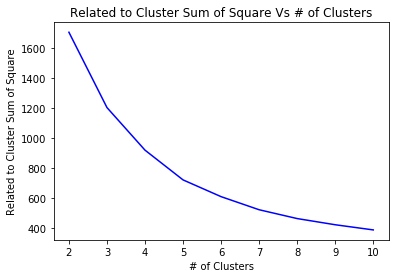

In [61]:
# Searching for elbow(optimal number of clusters)
# Average distance value to centroids
K_range = range(2,11)
y =[]

for k in K_range:
    k_means = KMeans(n_clusters= k, random_state = 1, init = 'k-means++')
    k_means.fit(sc_clust_test)
    labels=k_means.labels_
    y.append(k_means.inertia_)

plt.plot(K_range, y, color='blue')
plt.xlabel('# of Clusters')
plt.ylabel('Related to Cluster Sum of Square')
plt.title('Related to Cluster Sum of Square Vs # of Clusters')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.896543329323


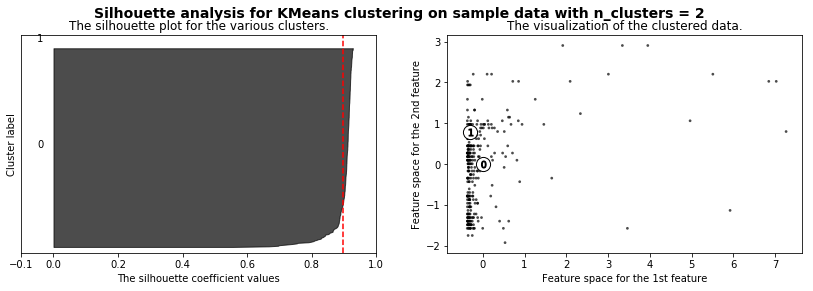

For n_clusters = 3 The average silhouette_score is : 0.641595150834


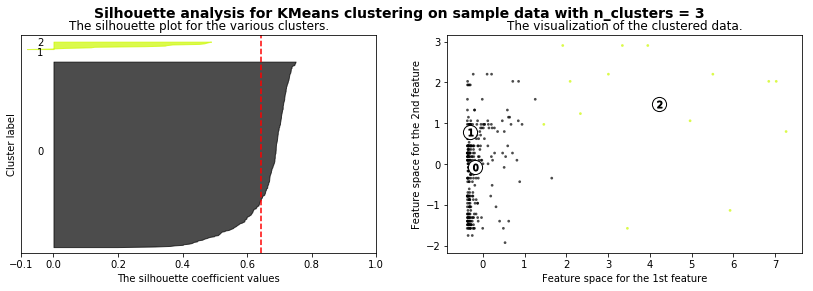

For n_clusters = 4 The average silhouette_score is : 0.290458217063


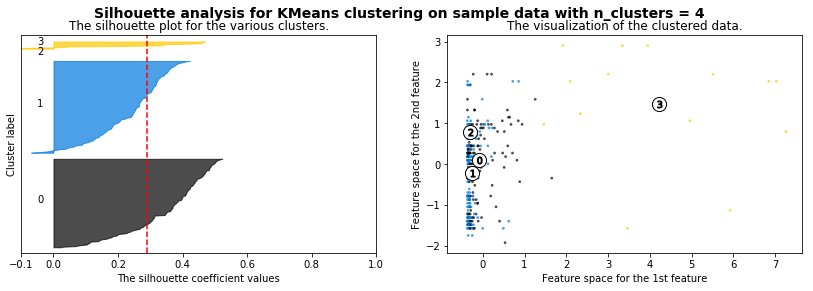

For n_clusters = 5 The average silhouette_score is : 0.317253696414


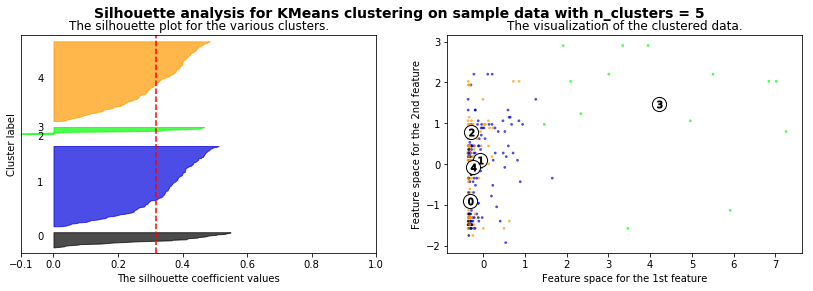

For n_clusters = 6 The average silhouette_score is : 0.311093567222


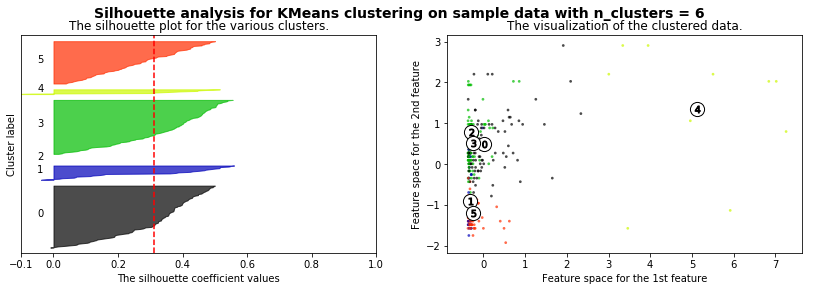

In [62]:
range_n_clusters = [2, 3, 4, 5, 6]
X= sc_clust_test

for n_clusters in range_n_clusters:
    
# SETTING THE PLOTS ONE ROW AND TWO COLUMNS FOR EACH SAMPLE, ALSO SETS THE SIZE OF EACH BOX
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)
    

# THE FIRST COLUMN BOX FOR EACH ROW(AX1) REPRESENTS THE GRAPH OF THE SILHOUETE COEFFICIENTS
   # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    
# IT FITS THE DATA AND PREDICT THE CENTROIDS/CLUSTERS 
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(sc_clust_test)
    
# IT CALCULATES THE AVERAGE SCORES FOR EACH # OF CLUSTERS, THE CLOSER TO ONE THE BETTER FIT   
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(sc_clust_test, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    
     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sc_clust_test, cluster_labels)
    
    
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

---